In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
OUT_DIR = Path('./out/tsne')

if not OUT_DIR.exists():
    OUT_DIR.mkdir(parents=True) 

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 10

# Load data

In [2]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])

## Scale Inputs

In [3]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.971476     0.685657
1  0.003003  0.971470     0.685389
2  0.005005  0.971463     0.685116
3  0.007007  0.971456     0.684838
4  0.008885  0.971450     0.684523


# Magnetic Field - B [G]

In [4]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]

array([0.97147607, 0.97146954, 0.971463  , 0.97145644, 0.97144987])

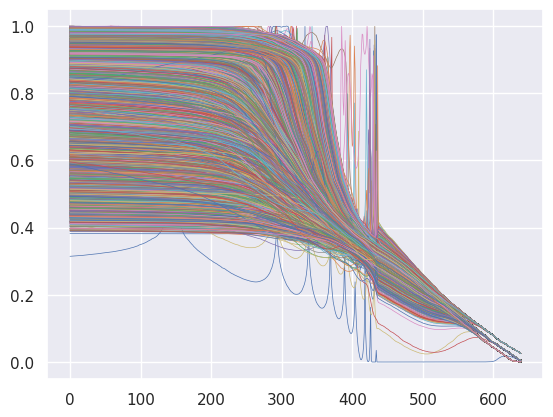

In [5]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

## TSNE

In [5]:
tsne = TSNE(n_components=2)
transformed_mag = tsne.fit_transform(scaled_magnetic)
transformed_mag

array([[-63.043404,  47.77151 ],
       [ 23.813051,  48.225628],
       [ 50.502094,  32.44247 ],
       ...,
       [-31.609037, -71.403595],
       [ 36.105133,  21.850885],
       [  8.713591, -31.22526 ]], dtype=float32)

<AxesSubplot: >

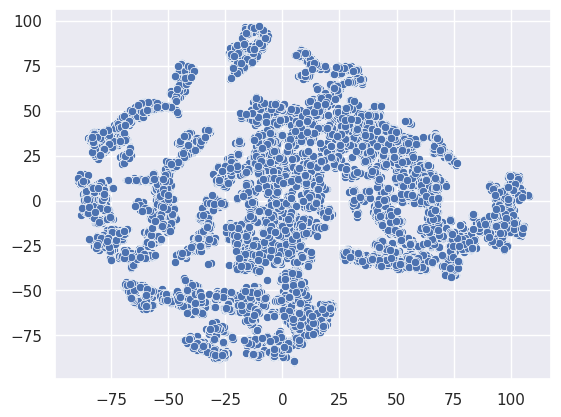

In [6]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

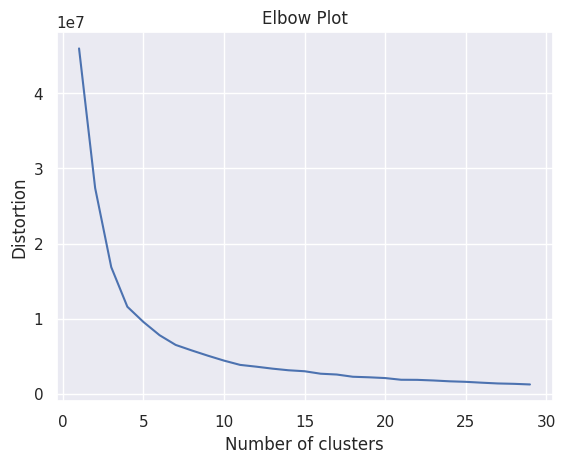

In [7]:
# Elbow Test
distortions = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_mag)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [10]:
silhouette_scores = {"n_clusters" : [], "silhouette_score" : []}
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, max_iter=5000, n_init='auto')
    labels = kmeans.fit_predict(transformed_mag)
    silhouette_avg = silhouette_score(transformed_mag, labels)
    silhouette_scores["n_clusters"].append(i)
    silhouette_scores["silhouette_score"].append(silhouette_avg)
pd.DataFrame(silhouette_scores, index=None)    

n_clusters  silhouette_score
0            2          0.375638
1            3          0.401258
2            4          0.419865
3            5          0.395808
4            6          0.375337
5            7          0.384700
6            8          0.386064
7            9          0.390115
8           10          0.383577
9           11          0.383124
10          12          0.394630
11          13          0.391699
12          14          0.375047
13          15          0.390545
14          16          0.375145
15          17          0.397447
16          18          0.385011
17          19          0.391930

In [11]:
kmeans = KMeans(n_clusters=4,max_iter=5000, n_init='auto')

pca_kmeans_mag_labels = kmeans.fit_predict(transformed_mag)

<AxesSubplot: >

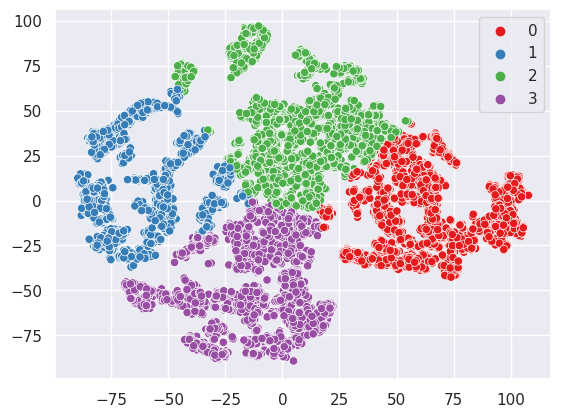

In [12]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=pca_kmeans_mag_labels, palette='Set1')

### Original Data

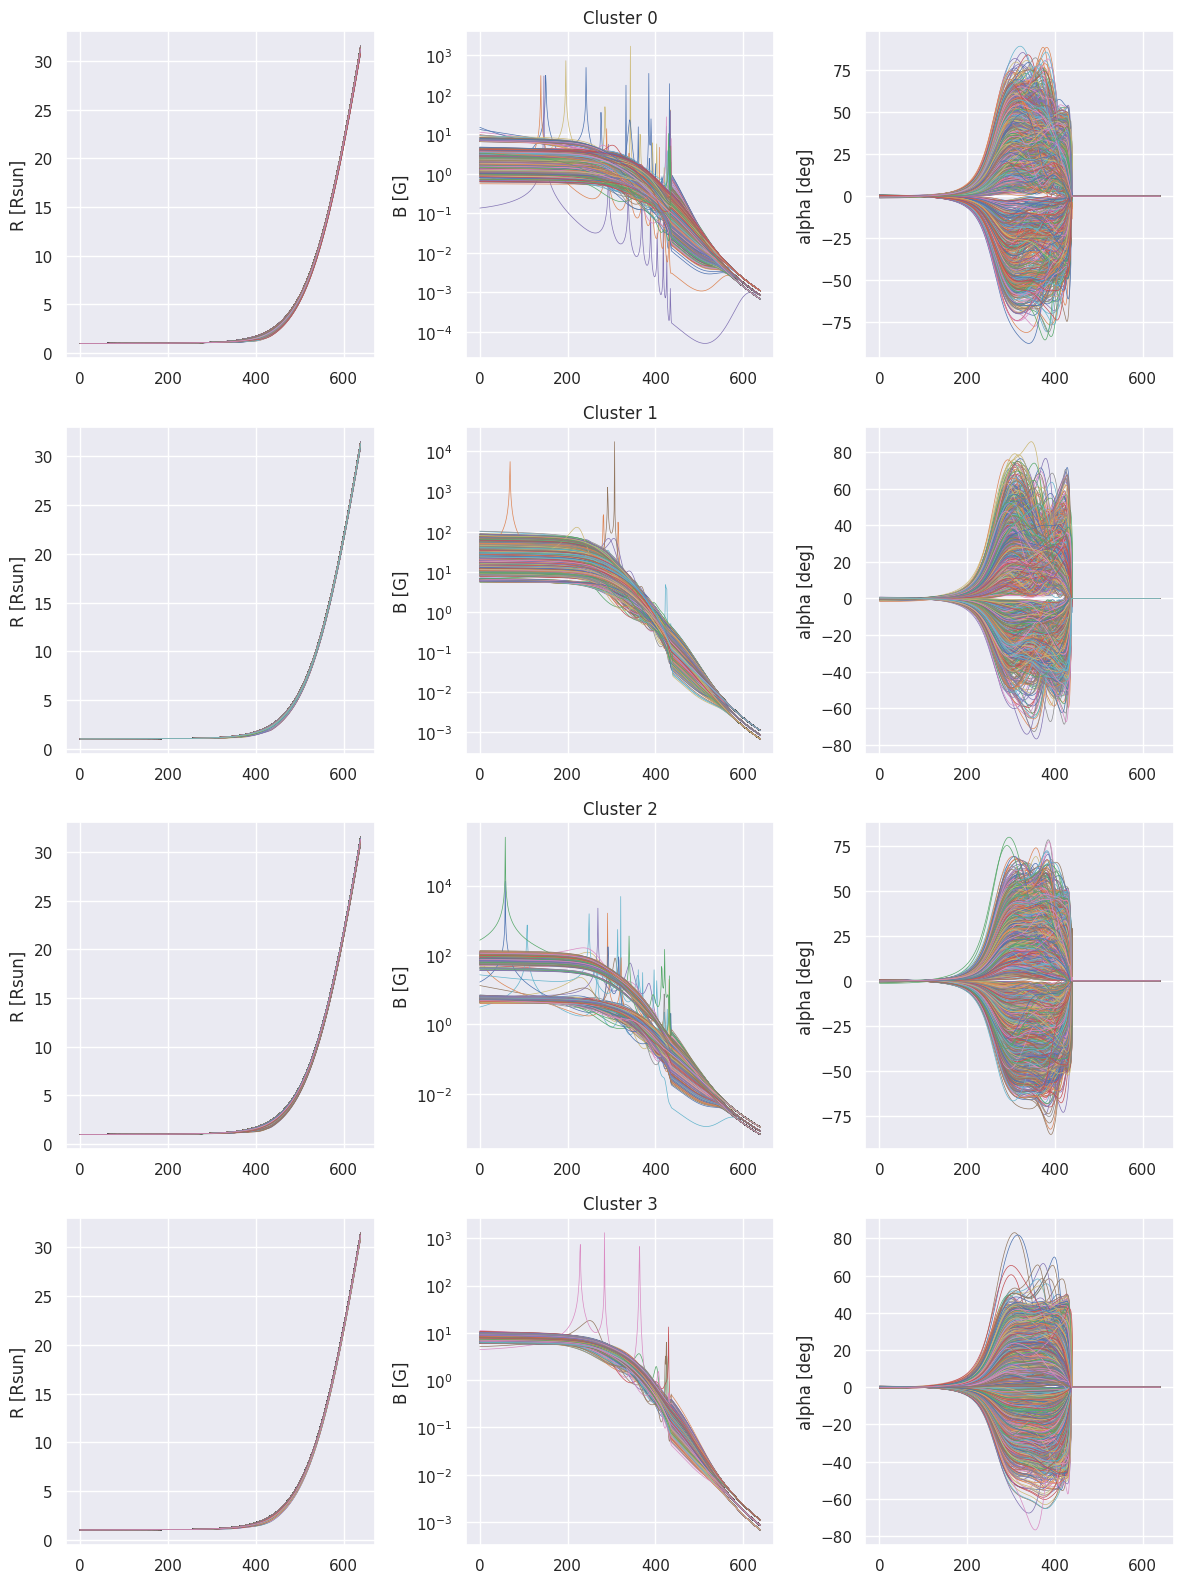

In [13]:
plot_unscaled_clusters(pca_kmeans_mag_labels, len(set(pca_kmeans_mag_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

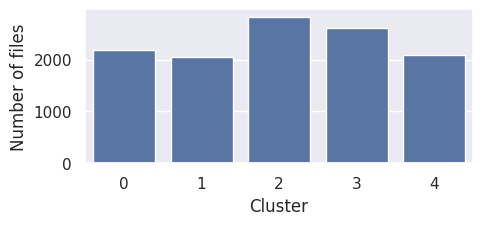

In [12]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [16]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag)

Text(0.5, 0, 'Number of points in node')

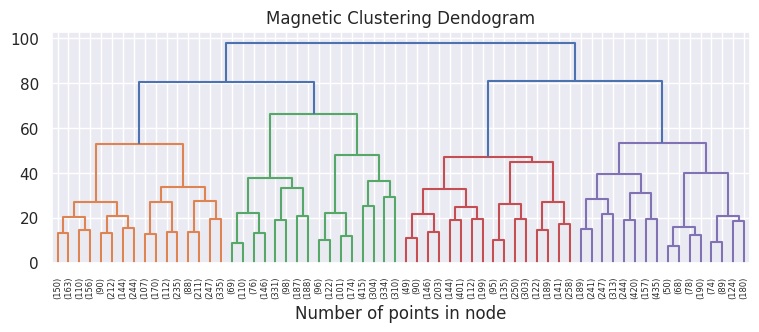

In [17]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=5)
plt.xlabel("Number of points in node")

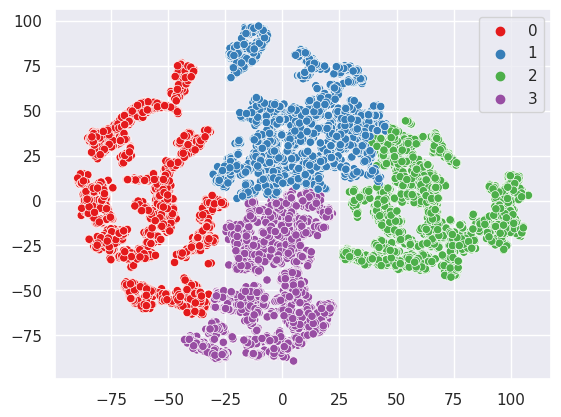

In [18]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

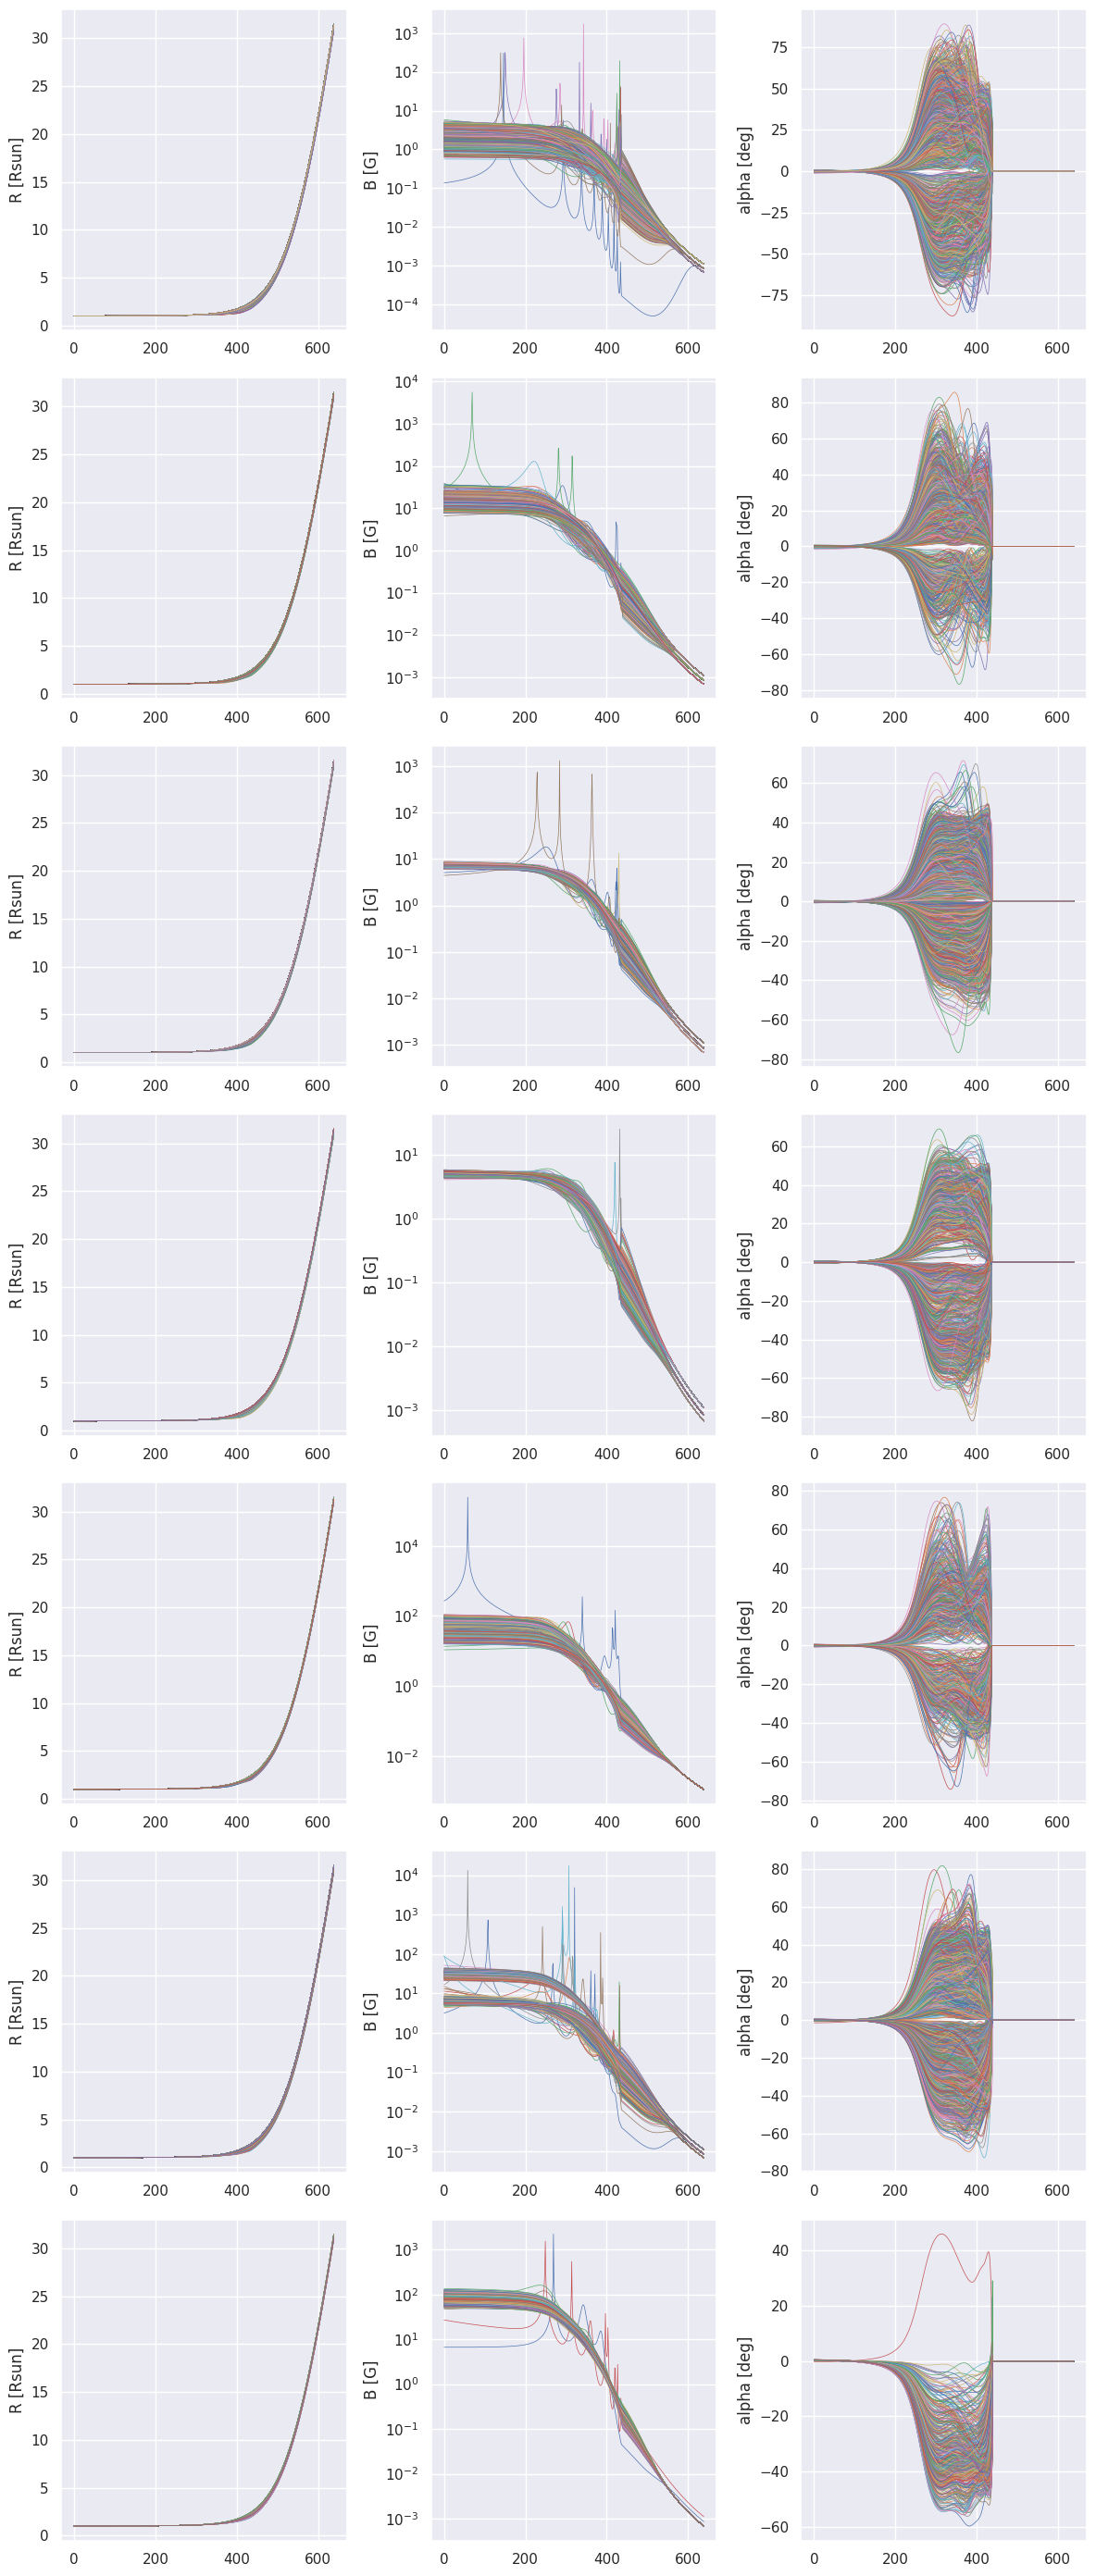

In [11]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

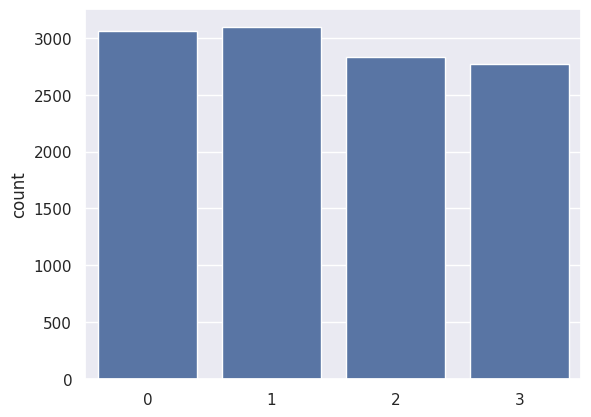

In [19]:
sns.countplot(x=agg.labels_, color='b')

In [18]:
# %%capture
# sub_dir = OUT_DIR / 'mag'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_mag)
    
#     sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'})
    

# Flux Tube Inclination - alpha [deg]

In [20]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.68565719, 0.68538948, 0.68511648, 0.68483813, 0.684523  ])

## TSNE

In [21]:
tsne = TSNE(n_components=2)
transformed_alpha = tsne.fit_transform(scaled_alpha)
transformed_alpha

array([[ 8.7029419e+01, -2.0821987e+01],
       [-7.2191521e+01,  2.9024137e+01],
       [-6.2317905e+01, -4.1862312e+01],
       ...,
       [-1.4397352e+01,  2.9976627e+01],
       [ 3.0186362e+00,  3.7886585e+01],
       [-7.4016319e+01,  2.4065278e-02]], dtype=float32)

### Transformed

<AxesSubplot: >

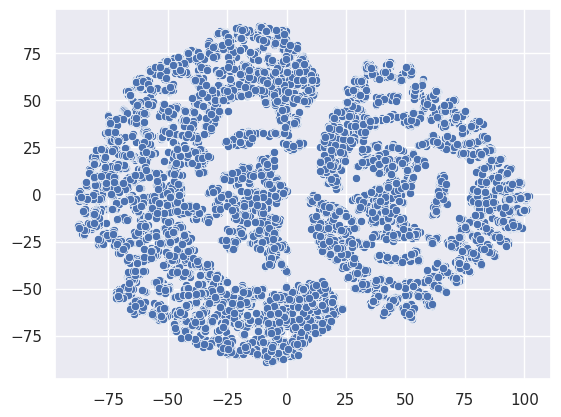

In [22]:
sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

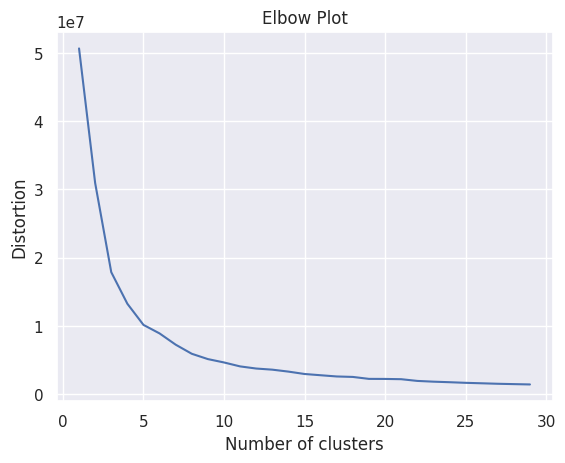

In [23]:
# Elbow Test
distortions = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_alpha)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [24]:
silhouette_scores = {"n_clusters" : [], "silhouette_score" : []}
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, max_iter=5000, n_init='auto')
    labels = kmeans.fit_predict(transformed_alpha)
    silhouette_avg = silhouette_score(transformed_alpha, labels)
    silhouette_scores["n_clusters"].append(i)
    silhouette_scores["silhouette_score"].append(silhouette_avg)
pd.DataFrame(silhouette_scores, index=None)    

n_clusters  silhouette_score
0           2          0.363735
1           3          0.409720
2           4          0.380015
3           5          0.368107
4           6          0.372553
5           7          0.393935
6           8          0.393234
7           9          0.400367

In [23]:
kmeans = KMeans(n_clusters=3,max_iter=5000, n_init='auto')

pca_kmeans_alpha_labels = kmeans.fit_predict(transformed_alpha)

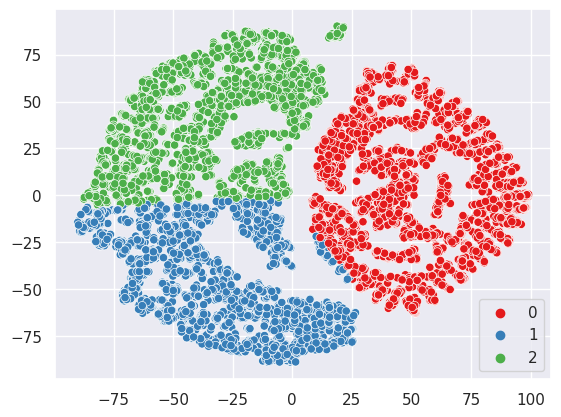

In [24]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=pca_kmeans_alpha_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

In [25]:
plot_unscaled_clusters(pca_kmeans_alpha_labels, len(set(pca_kmeans_alpha_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

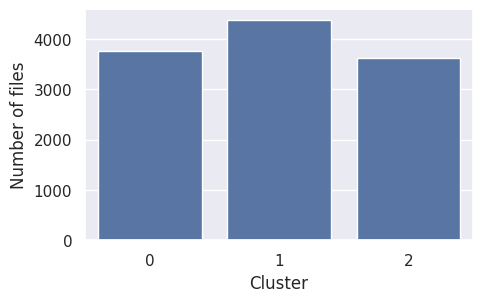

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [27]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=3, compute_full_tree=True, linkage='average')

agg = agg.fit(transformed_alpha)

Text(0.5, 0, 'Number of points in node')

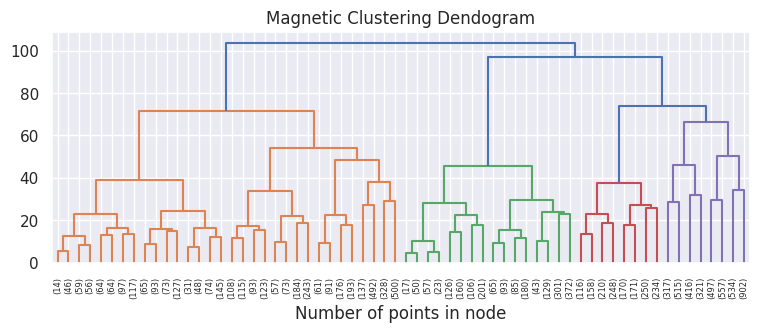

In [26]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=5)
plt.xlabel("Number of points in node")

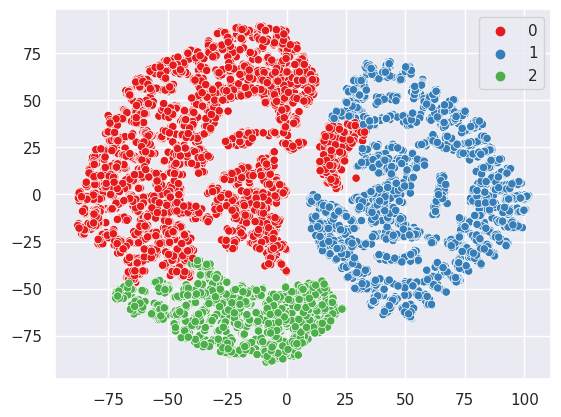

In [28]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

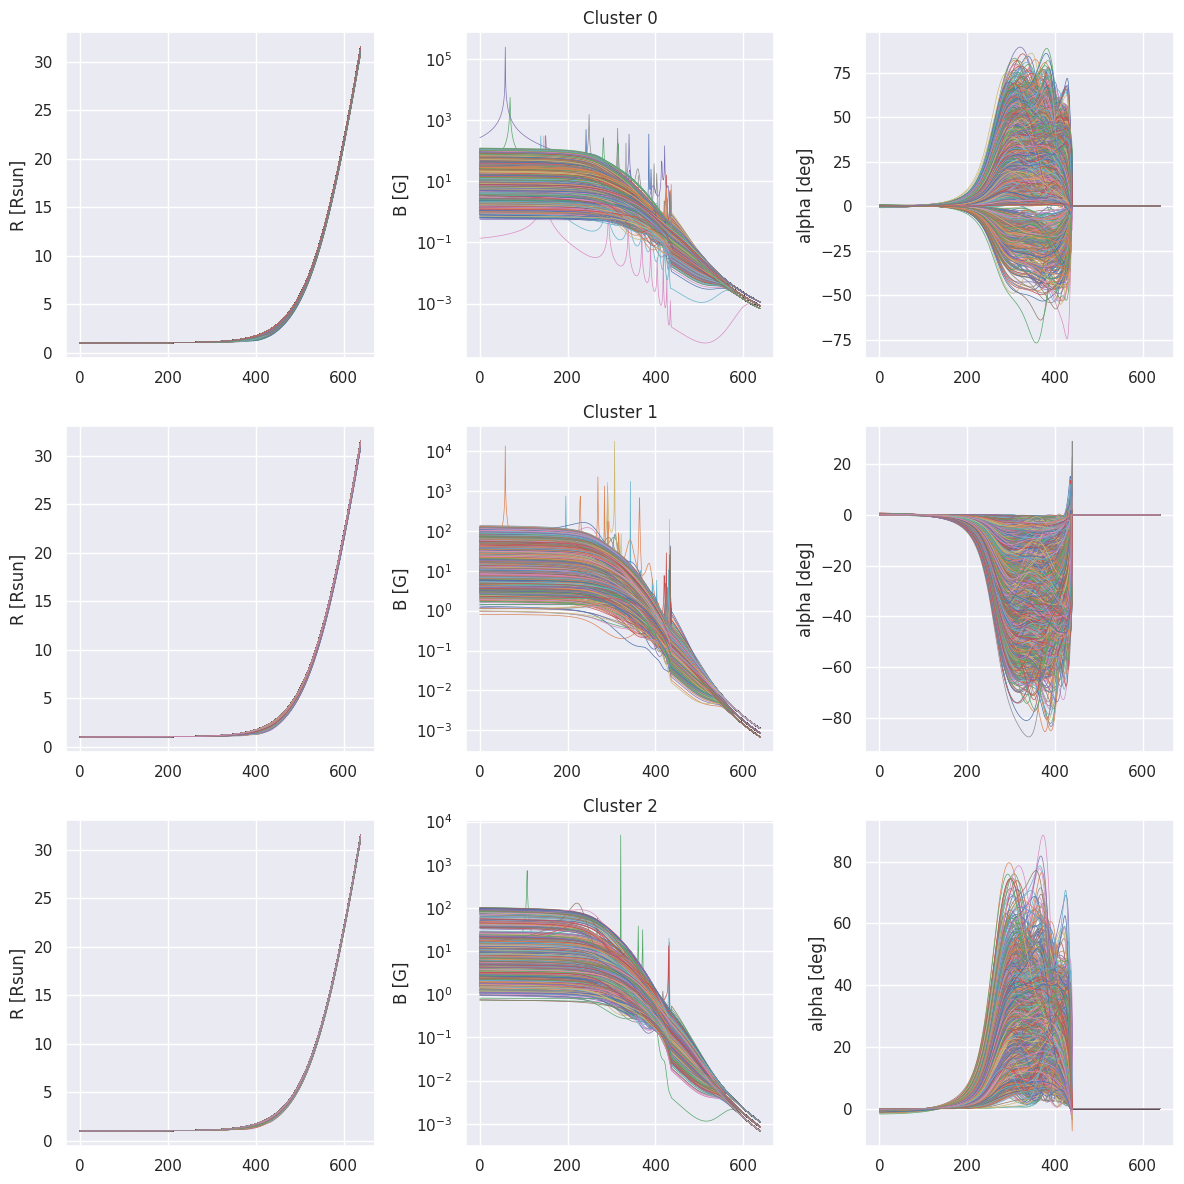

In [29]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

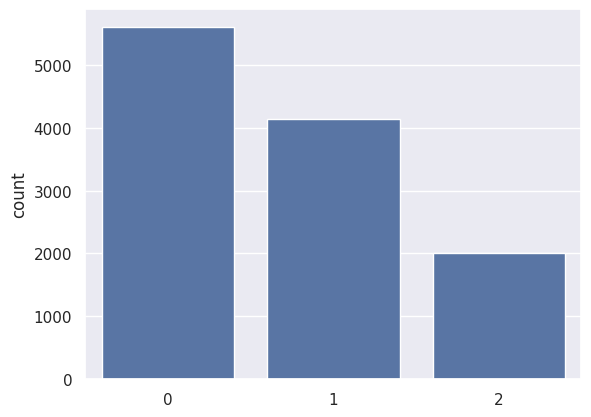

In [30]:
sns.countplot(x=agg.labels_, color='b')

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'alpha'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_alpha)
    
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'}) 
    